# Analysis pipeline for the project
Group Tarsier: Fabian Schmierer, Viraat Saaran, Batuhan, Salmanoglu, Maral Demirsecen

The notebook currently covers the following functionality:
- Read in tsv file of one participant
- Filter out all data that is not part of any trial
- Filter out duplicate fixations
- For each trial:
    - Plot the distribution of fixation durations
    - Plot x-position vs. time
    - Plot y-position vs. time
    - Generate scanpath visualization
    - Generate heatmap
- All visualizations are stored in a subfolder


In each trial, the user was given a task that he has to solve using a stacked barchart. The barchart changes in each experimental block. There are 5 blocks with 4 trials each. The user can stop looking at the visualization by pressing space. This ended the trial. Therefore trial duration varied during the experiment.

In [60]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

C:\Users\Fabia\AppData\Local\Temp\ipykernel_8892\1310096535.py:9: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


### Data read-in

In [61]:
df = pd.read_csv("test_data/subject-0.tsv",  sep='\t', header=0)
events = pd.read_csv("test_data/subject-0.csv")

df_valid = df[df['BPOGV'] == 1]

df_valid.shape[0]/df.shape[0]


0.9688491280387084

### Data preprocessing

Let us first drop all "uninteresting" columns.

In [62]:
df = df[['CNT', 'TIME', 'FPOGX', 'FPOGY', 'FPOGS', 'FPOGD', 'FPOGID', 'FPOGV', 'BPOGX', 'BPOGY', 'BPOGV', 'USER']]
events = events[['block_id', 'trial_id']]
num_blocks = max(events['block_id'].values)
trials_per_block = events.shape[0]//num_blocks

df['BPOGY'] = 1 - df['BPOGY']
df['FPOGY'] = 1 - df['FPOGY']
df

,CNT,TIME,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,BPOGX,BPOGY,BPOGV,USER
0,96506,1563.16760,0.12051,0.48648,1563.07080,0.09680,1585,1,0.13474,0.50034,1,SHOW_FIXATION_CROSS
1,96507,1563.18396,0.12159,0.48775,1563.07080,0.11316,1585,1,0.12911,0.49667,1,NaN
2,96508,1563.19995,0.12178,0.48958,1563.07080,0.12915,1585,1,0.12331,0.50420,1,NaN
3,96509,1563.21619,0.12143,0.49171,1563.07080,0.14539,1585,1,0.11830,0.51088,1,NaN
4,96510,1563.23230,0.12131,0.49144,1563.07080,0.16150,1585,1,0.12009,0.48870,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
68404,168026,2720.06152,0.50366,0.69293,2719.99683,0.06470,4276,1,0.50202,0.67174,1,NaN
68405,168027,2720.07764,0.50312,0.69201,2719.99683,0.08081,4276,1,0.50037,0.68739,1,NaN
68406,168028,2720.09399,0.50161,0.68944,2719.99683,0.09717,4276,1,0.49256,0.67405,1,NaN
68407,168029,2720.11011,0.50041,0.68836,2719.99683,0.11328,4276,1,0.49204,0.68077,1,NaN


There is a lot of useless data in the raw dataset, e.g. all captured data during recalibrations or during task presentation before the stimulus has been shown.
We want to filter that out.

In [63]:
trial_starts = df[df['USER'].str.contains('SHOW_STIMULUS', na=False)].index.tolist()
trial_ends = df[df['USER'].str.contains('HIDE_STIMULUS', na=False)].index.tolist()

The plan was to analyze accuracy and precision with the data we obtained when the user has to look onto a fixation cross while we check if a recalibration is necessary.
Unfortunately, some SHOW_FIXATION_CROSS messages were lost and their HIDE_FIXATION_CROSS counterparts can be found after the trial has already stopped. 
At the moment we do not know exactly the reason for this bug.

In [64]:
fixation_starts = df[df['USER'].str.contains('SHOW_FIXATION_CROSS', na=False)].index.tolist()
fixation_ends = df[df['USER'].str.contains('HIDE_FIXATION_CROSS', na=False)].index.tolist()

In [65]:
df_without_duplicates = df.drop_duplicates(subset='FPOGID', keep='last')

To make the further analysis easier, we construct 2 lists:
1. The "trials_duplicates" list contains the raw data for each trial combined with the corresponding block_id and trial_id that was obtained from the events dataset
2. The "trials" dataset where all duplicates (fixations with the same id) have been filtered out.

**Furthermore, we prefilter the data so that only valid fixations are shown.**

In [66]:
trials = []
trials_duplicates = []

for i in range(0, len(trial_starts)):
    block_id = events['block_id'].iloc[i]
    trial_id = events['trial_id'].iloc[i]

    trial_df_duplicates = df.iloc[trial_starts[i]:trial_ends[i]]
    trial_df_duplicates = trial_df_duplicates[trial_df_duplicates['BPOGV'] == 1]
    trial_df = trial_df_duplicates.drop_duplicates(subset='FPOGID', keep='last')

    trials_duplicates.append((block_id, trial_id, trial_df_duplicates))
    trials.append((block_id, trial_id, trial_df))

#for trial in trials:
#    print(trial[0], trial[1], trial[2]['CNT'].iloc[0])

## Data visualization
We start with a histogram of the fixation durations of the complete dataset. Duplicates (fixations with the same id) have been filtered out. 

**Important**: Some "unusually" long fixations migth be visible in the visualization. These might originate from the fact that participants looked at visualizations, where
it might be possible that they concentrated on one data item quite some time.

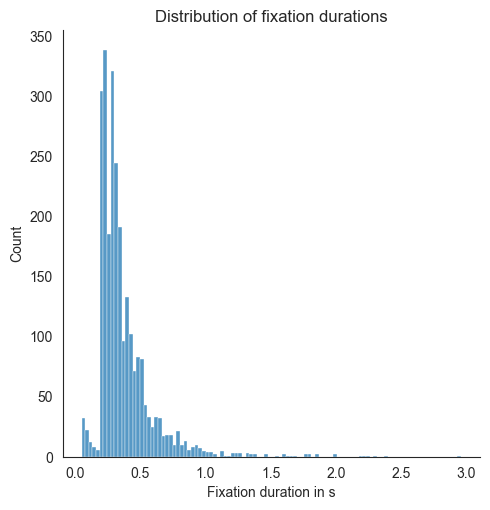

In [67]:
sns.displot(df_without_duplicates, x="FPOGD")
plt.title('Distribution of fixation durations')
plt.ylabel('Count')
plt.xlabel('Fixation duration in s')
plt.show()

In a next step we will plot the x-traces and y-traces vs. time. 

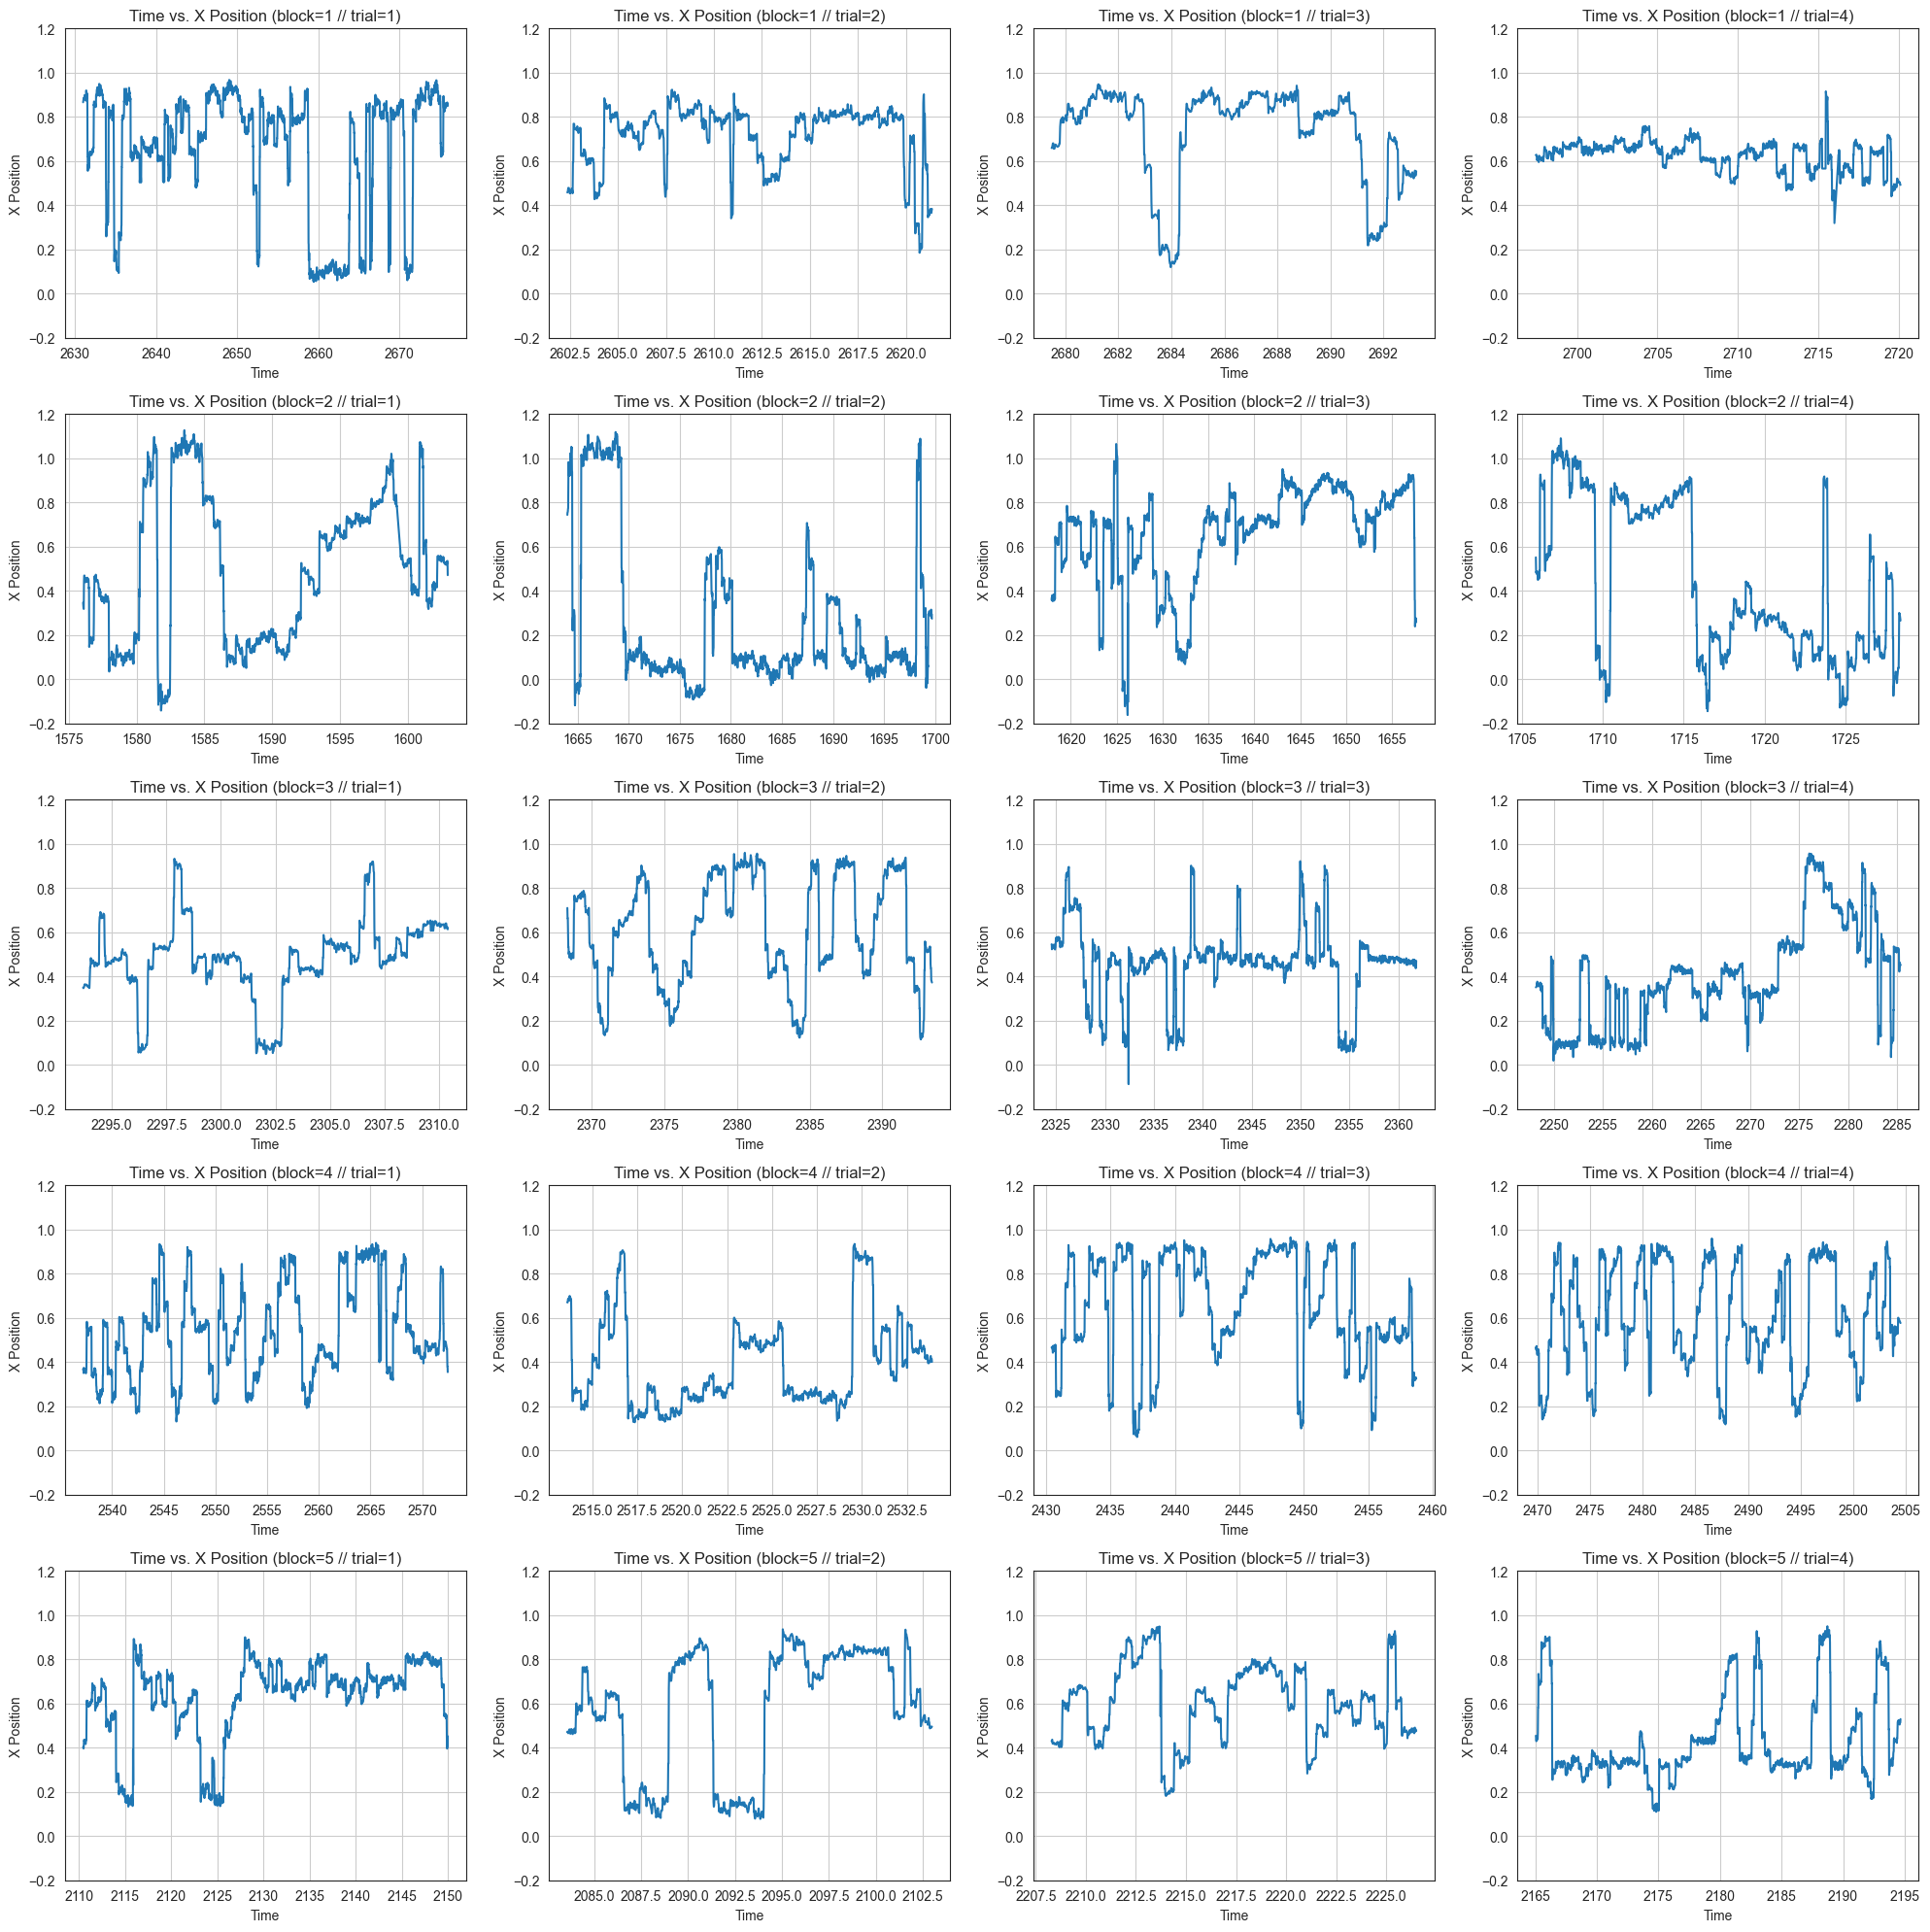

In [68]:
compact_visualizations = True

if compact_visualizations:
    plt.figure(figsize=(20, 20))
    for trial in trials_duplicates:
        plt.subplot(num_blocks, trials_per_block, ((trial[0]-1)*trials_per_block) + trial[1])
        sns.lineplot(data=trial[2], x='TIME', y='BPOGX')
        plt.title('Time vs. X Position (block='+str(trial[0])+' // trial='+str(trial[1])+')')
        plt.xlabel('Time')
        plt.ylabel('X Position')
        plt.grid(True)
        plt.ylim((-0.2,1.2))

    plt.tight_layout()
    plt.show()
else:    
    for trial in trials_duplicates:
        plt.figure(figsize=(20, 5))
        sns.lineplot(data=trial[2], x='TIME', y='BPOGX')
        plt.title('Time vs. X Position (block='+str(trial[0])+' // trial='+str(trial[1])+')')
        plt.xlabel('Time')
        plt.ylabel('X Position')
        plt.grid(True)
        plt.ylim((-0.2,1.2))
        plt.tight_layout()
        plt.show()


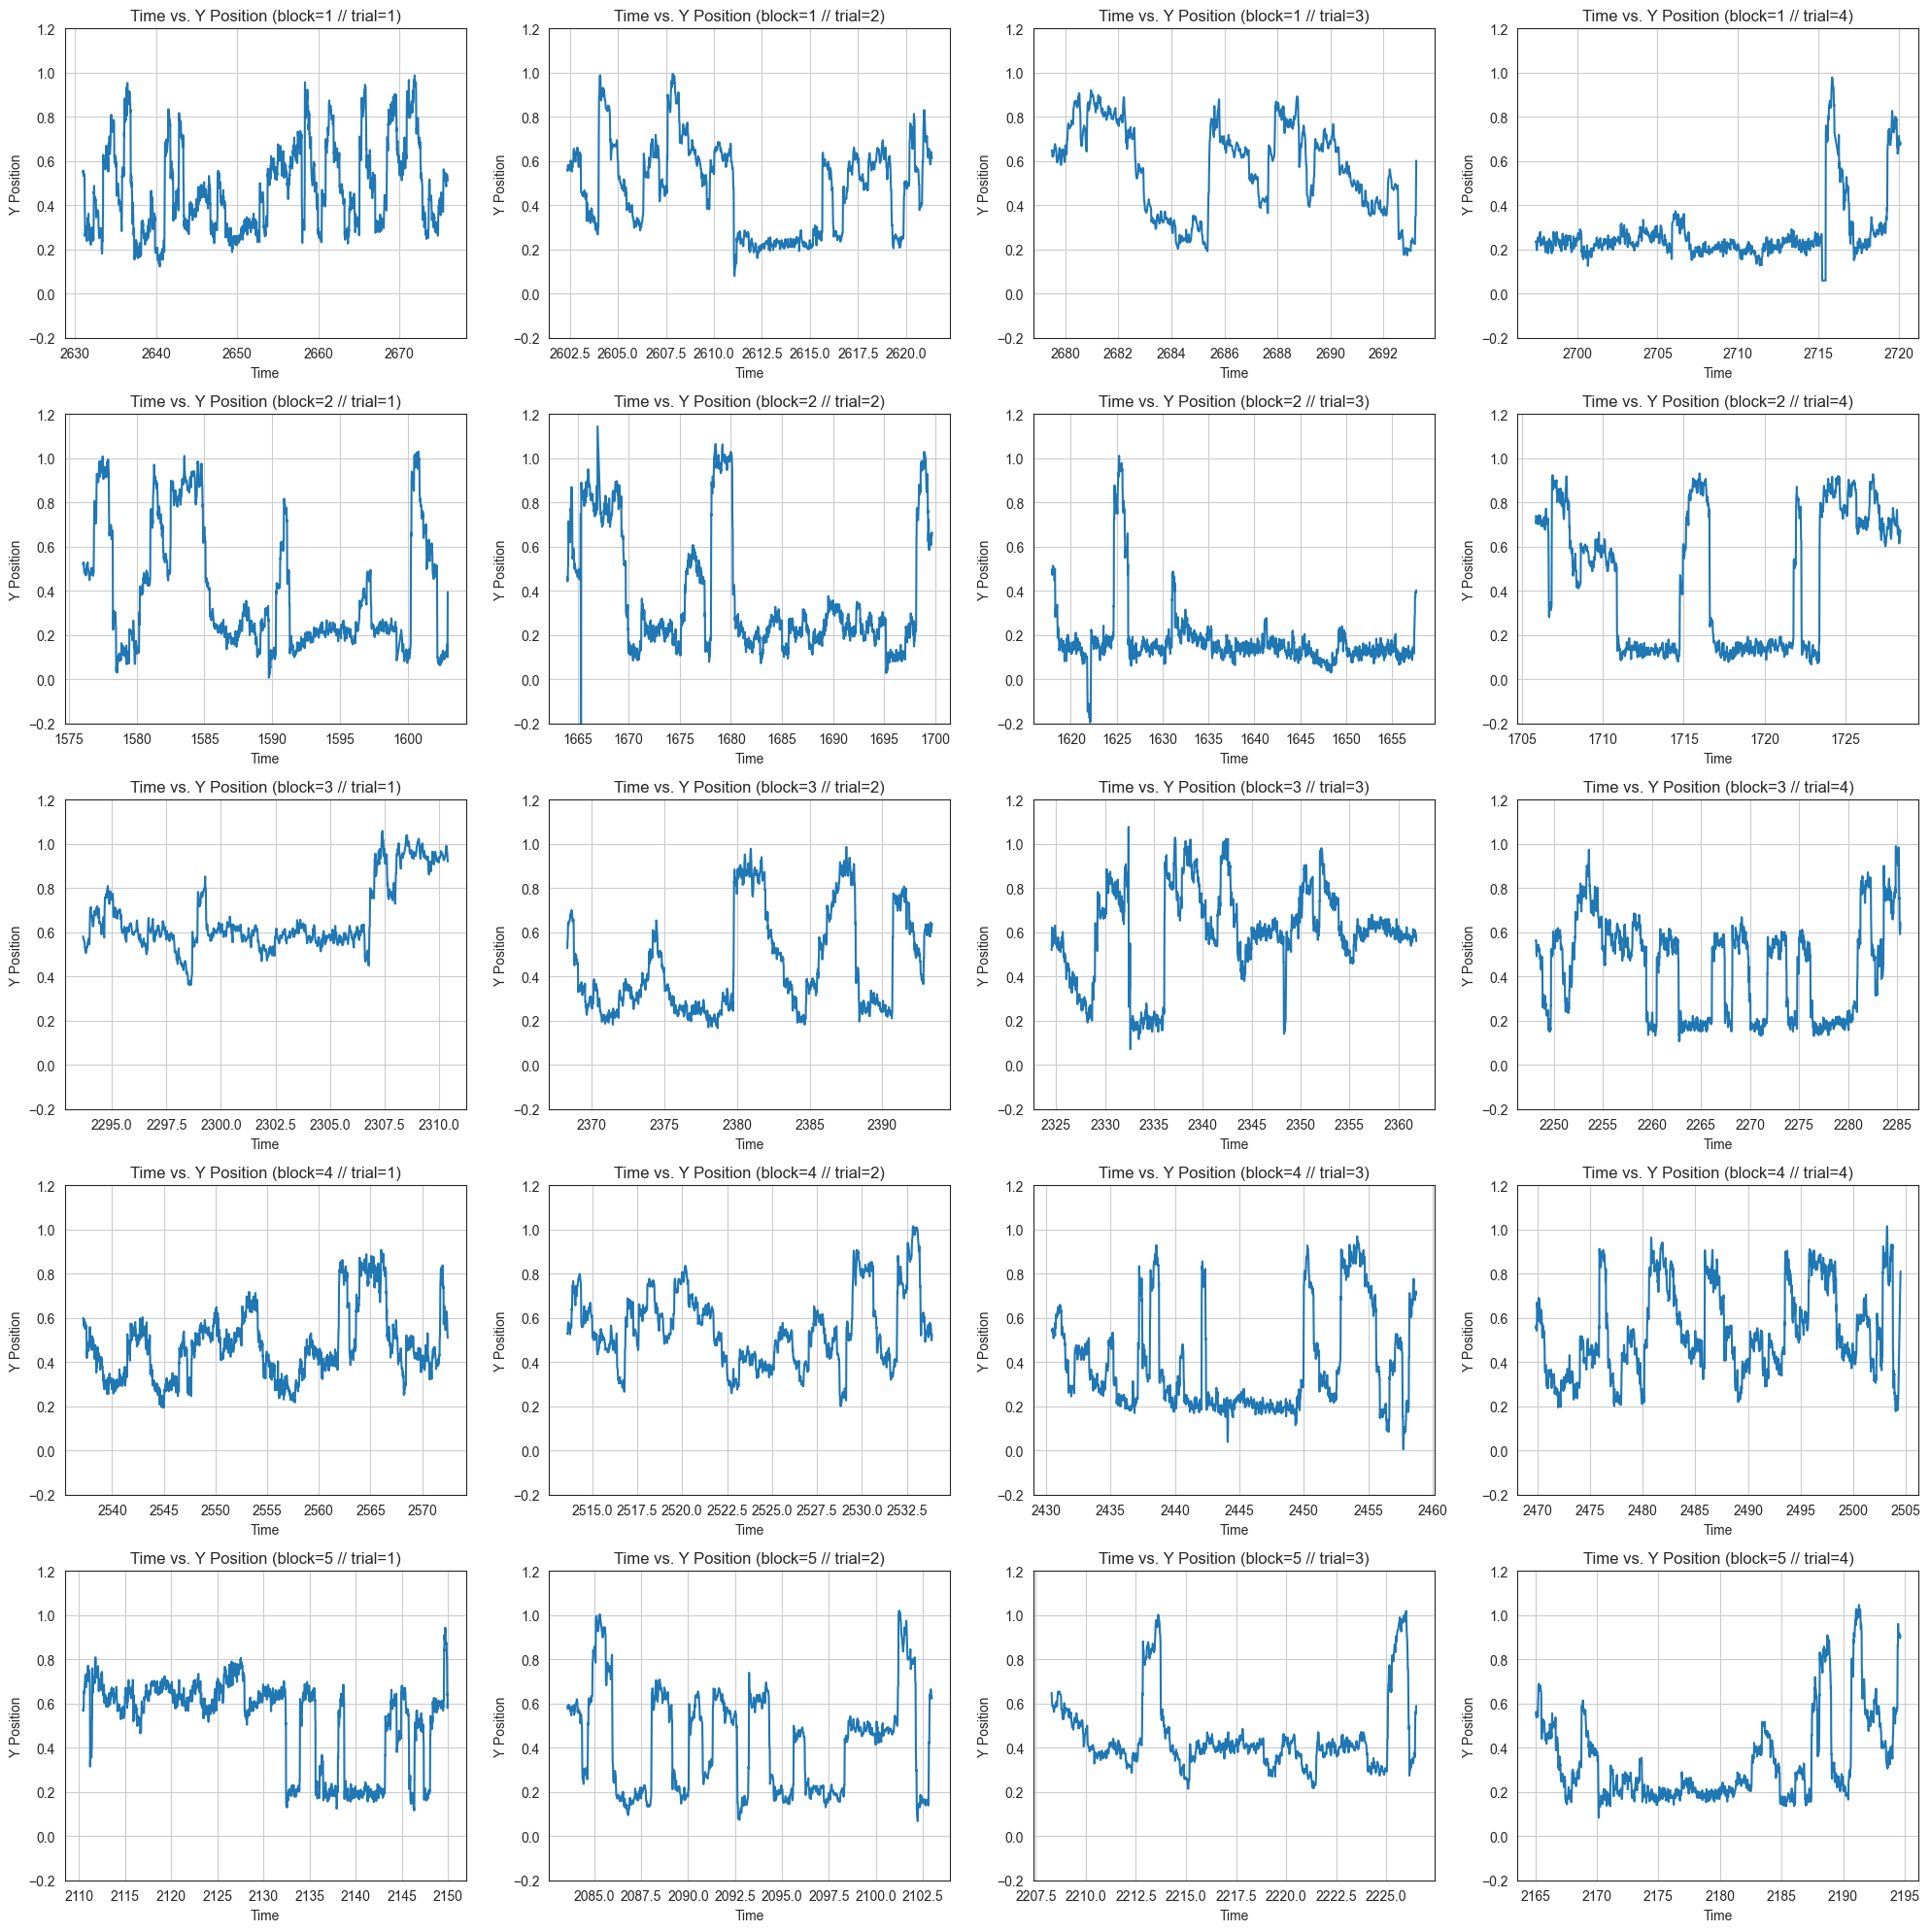

In [69]:
compact_visualizations = True
if compact_visualizations:
    plt.figure(figsize=(20, 20))

    for trial in trials_duplicates:
        plt.subplot(num_blocks, trials_per_block, ((trial[0]-1)*trials_per_block) + trial[1])
        sns.lineplot(data=trial[2], x='TIME', y='BPOGY')
        plt.title('Time vs. Y Position (block='+str(trial[0])+' // trial='+str(trial[1])+')')
        plt.xlabel('Time')
        plt.ylabel('Y Position')
        plt.grid(True)
        plt.ylim((-0.2,1.2))

    plt.tight_layout()
    plt.show()

else:
    for trial in trials_duplicates:
        plt.figure(figsize=(20, 5))
        sns.lineplot(data=trial[2], x='TIME', y='BPOGY')
        plt.title('Time vs. Y Position (block='+str(trial[0])+' // trial='+str(trial[1])+')')
        plt.xlabel('Time')
        plt.ylabel('Y Position')
        plt.grid(True)
        plt.ylim((-0.2,1.2))
        plt.tight_layout()
        plt.show()

In [70]:
tasks = [
    [
        "How do you predict the total sales (in millions) \n will develop over the next 5 years?",
        "In which year did the kitchen devices division record the highest sales?",
        "Which division made the most sales?",
        "Are there any problems in the visualization?"
    ],
    [
        "Do you think that game sales will increase next year?",
        "What were the sales of kitchen devices in 2007?",
        "In which year was there the biggest outlier in sales?",
        "In which year had the TV division the highest contribution to overall sales?"
    ], 
    [
        "What is the estimated average of total sales over all years?",
        "Assume you are a manager and you need to close one division? \n Which one would it be?",
        "Try to memorize the content of the visualization.",
        "In which years the the company have sales between 60 and 80 Million Dollars?"
    ],
    [
    	"Summarize what you can observe in the visualization.",
        "Which division had the largest growth in sales \n between to consecutive years?",
        "In which year did the biggest decrease in overall sales happen? \n Estimate the shrinkage.",
        "Your sales are not looking good. \n In which division, based on the information you have, \n would you invest money to save the company?"
    ],
    [
        "Which two years had exactly the same sales?",
        "In which year were the sales of the kitchen division larger: 1985 or 2017?",
        "Are there divisions where the sales numbers correlate? \n If yes, which ones?",
        "Assume you are the new manager \n of the kitchen device division and inspect the data. \n Do you find any sales numbers of your department \n that look strange in your eyes?"
    ]
]

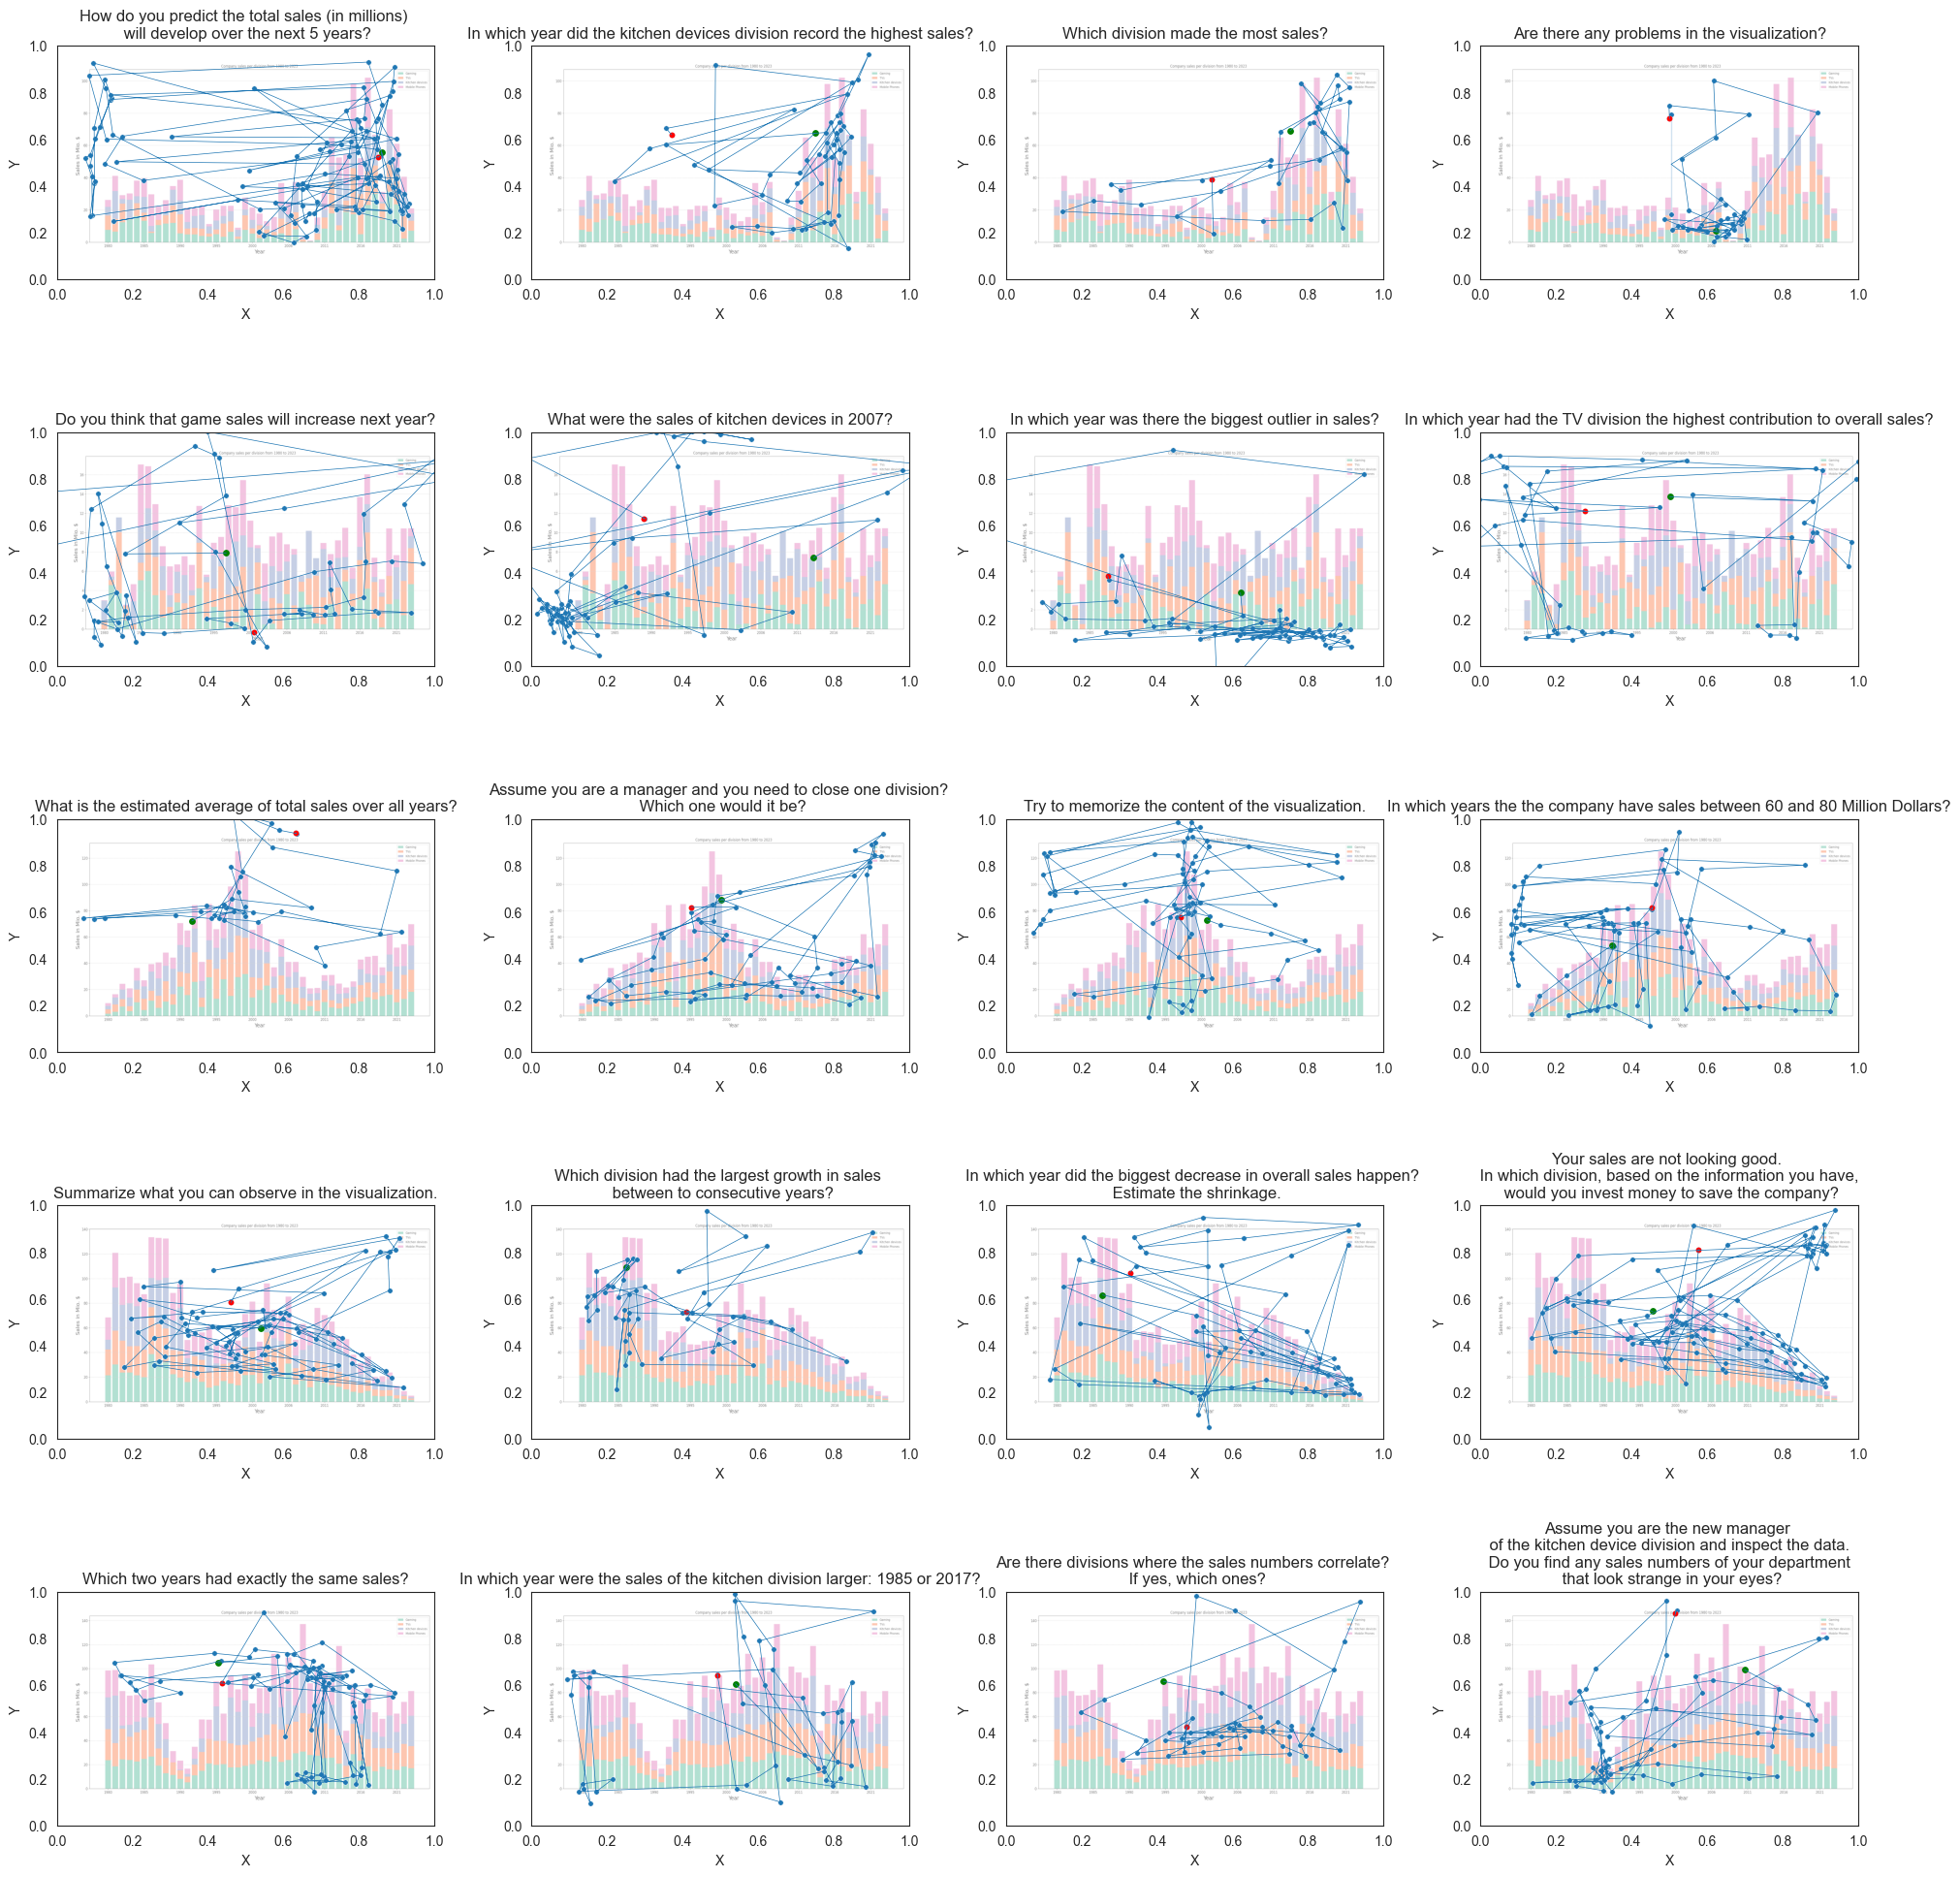

In [73]:
compact_visualizations = True

trials = sorted(trials, key=lambda x: (x[0], x[1]))

if compact_visualizations:
    plt.figure(figsize=(20, 20))

    for trial in trials:
        data = trial[2]

        plt.subplot(num_blocks, trials_per_block, ((trial[0]-1)*trials_per_block) + trial[1])
        sns.lineplot(data=data, x='FPOGX', y='FPOGY', linewidth=0.5, sort=False)
        sns.scatterplot(data=data, x='FPOGX', y='FPOGY', s=15)

        # Mark start point
        plt.scatter(data.iloc[0]['FPOGX'], data.iloc[0]['FPOGY'], color='g', s=15)  
        # Mark end point
        plt.scatter(data.iloc[data.shape[0]-1]['FPOGX'], data.iloc[data.shape[0]-1]['FPOGY'], color='r', s=10)   

        img = plt.imread('Visualizations/Test'+str(trial[0])+'.png')
        plt.imshow(img, extent=[0, 1, 0.0486 ,1-0.0486], aspect="auto", alpha=0.5)  

        plt.xlim(0, 1)
        plt.ylim(0, 1)

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(tasks[trial[0]-1][trial[1]-1])
        plt.grid(False)


    plt.tight_layout(pad=3.0)
    plt.show()
else:
    

    for trial in trials:
        data = trial[2]
        plt.figure(figsize=(20, 20/(1920/975)))
        sns.lineplot(data=data, x='FPOGX', y='FPOGY', linewidth=0.5, sort=False)
        sns.scatterplot(data=data, x='FPOGX', y='FPOGY', s=15)

        # Mark start point
        plt.scatter(data.iloc[0]['FPOGX'], data.iloc[0]['FPOGY'], color='g', s=15)  
        # Mark end point
        plt.scatter(data.iloc[data.shape[0]-1]['FPOGX'], data.iloc[data.shape[0]-1]['FPOGY'], color='r', s=15)   

        img = plt.imread('Visualizations/Test'+str(trial[0])+'.png')
        plt.imshow(img, extent=[0, 1, 0.0486 ,1-0.0486], aspect="auto", alpha=0.5)  

        plt.xlim(0, 1)
        plt.ylim(0, 1)

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(tasks[trial[0]-1][trial[1]-1])
        plt.grid(False)

        plt.tight_layout(pad=3.0)
        plt.show()

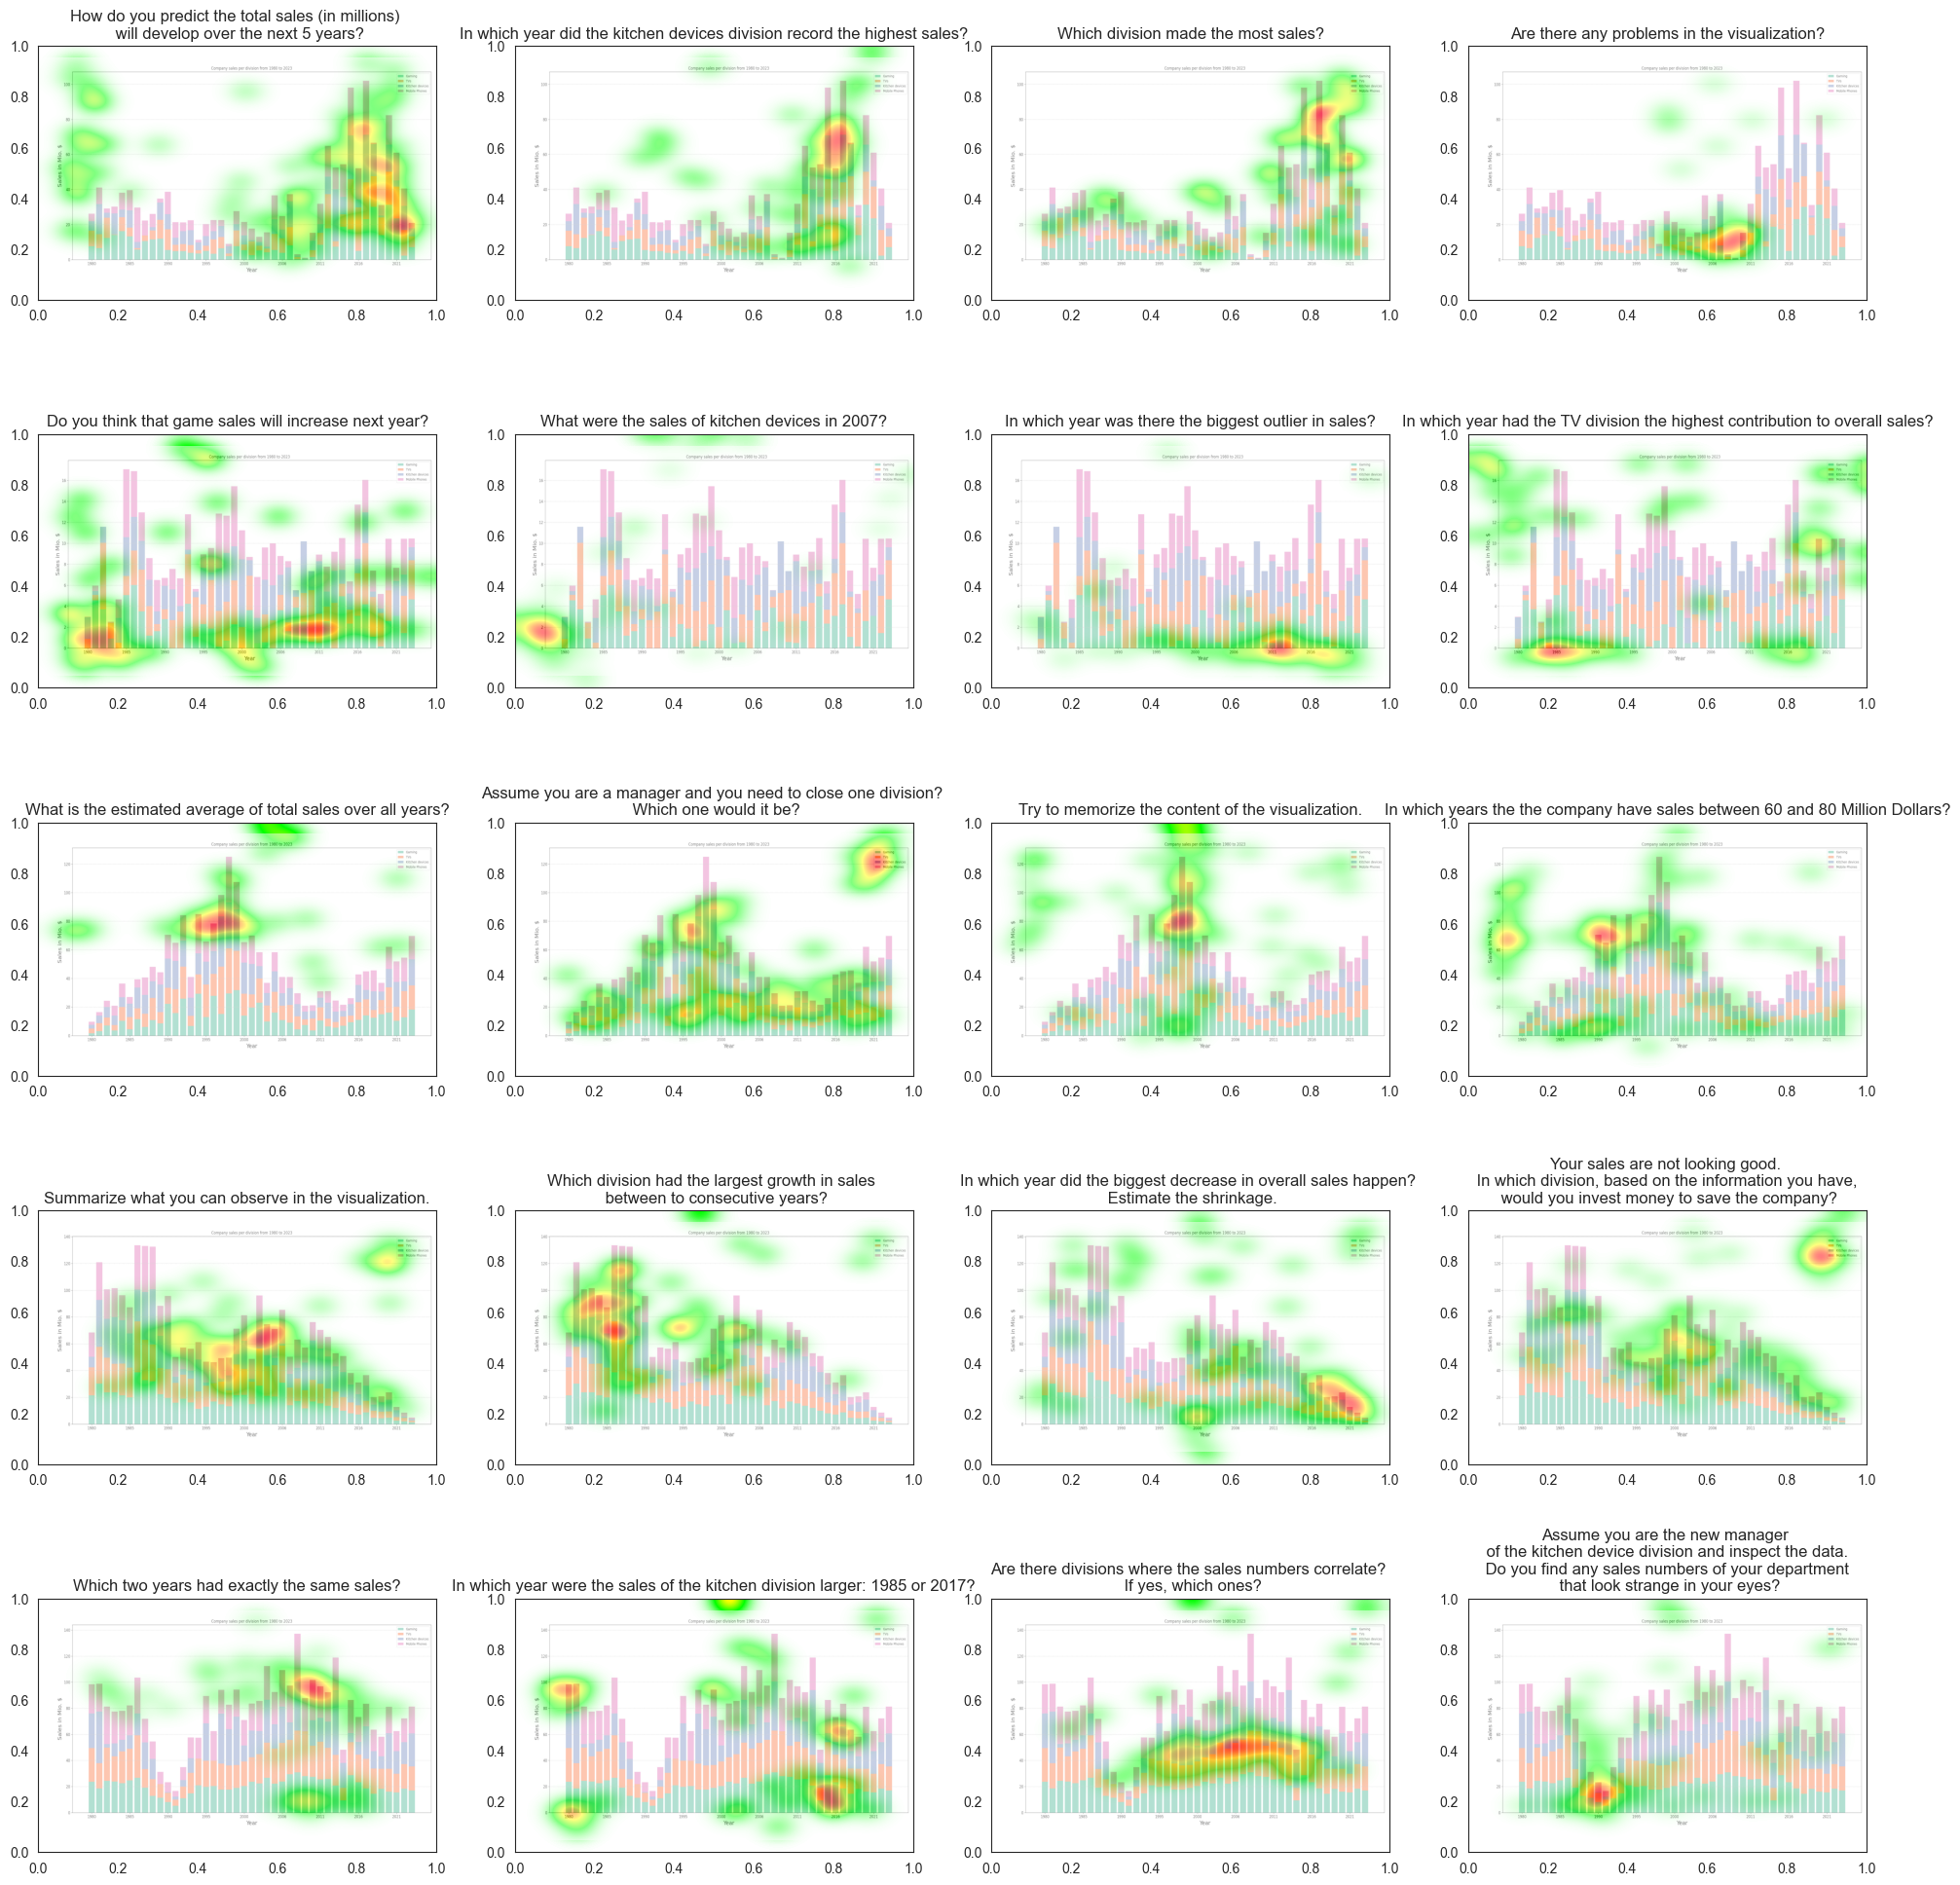

In [72]:
compact_visualizations = True

from matplotlib.colors import LinearSegmentedColormap

def generate_heatmap(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[[0,1], [0,1]])
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

colors = [(1, 1, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)]
cmap_name = 'custom_colormap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

std_dev = 32


if compact_visualizations:
    plt.figure(figsize=(20, 20))

    for trial in trials:
        data = trial[2]
        plt.subplot(num_blocks, trials_per_block, ((trial[0]-1)*trials_per_block) + trial[1])

        x = data['FPOGX'].values
        y = data['FPOGY'].values

        img, extent = generate_heatmap(x, y, std_dev)

        plt.imshow(img, extent=extent, origin='lower', cmap=custom_cmap)
        plt.title(tasks[trial[0]-1][trial[1]-1])

        img = plt.imread('Visualizations/Test'+str(trial[0])+'.png') 
        plt.imshow(img, extent=[0, 1, 0.0486 ,1-0.0486], aspect='auto', alpha=0.5)   

        plt.xlim(0, 1)
        plt.ylim(0, 1)


    plt.tight_layout(pad=3.0)
    plt.show()

else:
    

    for trial in trials:
        data = trial[2]
        plt.figure(figsize=(20, 20/(1920/975)))

        x = data['FPOGX'].values
        y = data['FPOGY'].values

        img, extent = generate_heatmap(x, y, std_dev)

        plt.imshow(img, extent=extent, origin='lower', cmap=custom_cmap)
        plt.title(tasks[trial[0]-1][trial[1]-1])

        img = plt.imread('Visualizations/Test'+str(trial[0])+'.png') 
        plt.imshow(img, extent=[0, 1, 0.0486 ,1-0.0486], aspect='auto', alpha=0.5)   

        plt.xlim(0, 1)
        plt.ylim(0, 1)

        plt.tight_layout(pad=3.0)
        plt.show()
